In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, utils, datasets, models
from PIL import Image
import os
import math
import random
import numpy as np
import torchbnn as bnn
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [10]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ",device)

Device:  cuda


In [11]:
batch_size=2
accumulation_steps=8
lr = 1e-4

In [12]:
class RandomInvertBackground:
    def __init__(self, p=0.3):
        self.p = p  # probability of inverting background

    def __call__(self, img):
        if torch.rand(1).item() < self.p:
            return 1.0 - img  # invert pixel values (black ↔ white)
        return img


In [13]:
train_transform = transforms.Compose([
    #transforms.RandomVerticalFlip(p=0.5),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    RandomInvertBackground(p=0.3),  # 30% images have inverted backgrounds
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    transforms.Normalize((0.1307,), (0.3081,))
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

transform_original = transforms.Compose([transforms.ToTensor()])


In [14]:
train_dataset = datasets.MNIST(root='./data', train=True, download=False, transform=train_transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=False, transform=val_transform)
dataset_original = datasets.MNIST(root="./data", train=True, download=False, transform=transform_original)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


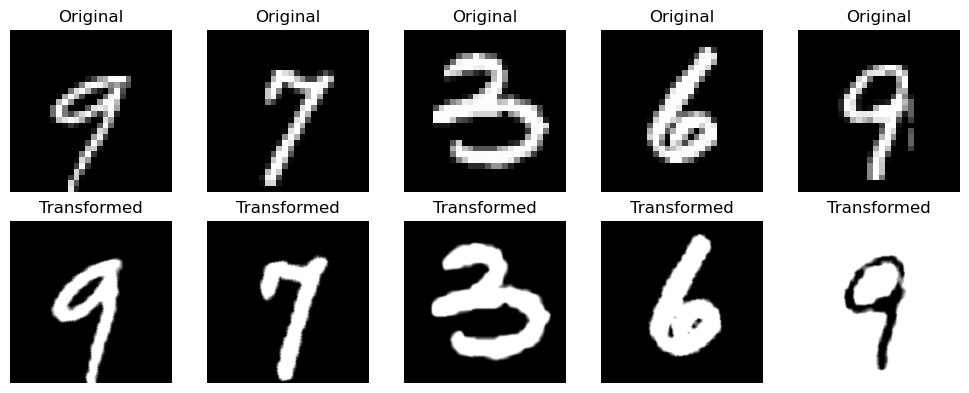

In [8]:
indices = random.sample(range(len(dataset_original)), 5)

plt.figure(figsize=(10, 4))
for i, idx in enumerate(indices):
    orig_img, _ = dataset_original[idx]
    aug_img, _ = train_dataset[idx]

    # Original image
    plt.subplot(2, 5, i + 1)
    plt.imshow(orig_img.squeeze(), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Transformed image
    plt.subplot(2, 5, i + 6)
    aug_img_vis = aug_img.clone().permute(1, 2, 0).cpu().numpy() #* 0.3081 + 0.1307  # Unnormalize
    plt.imshow(aug_img_vis, cmap="gray")
    plt.title("Transformed")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [15]:
calib_size = len(test_dataset) // 2
test_size = len(test_dataset) - calib_size

calib_dataset, final_test_dataset = random_split(test_dataset, [calib_size, test_size], generator=torch.Generator().manual_seed(42))

In [16]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
calib_loader = DataLoader(calib_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(final_test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
images, labels = next(iter(test_loader))
print(images.shape)   # shape of the input batch
print(labels.shape)   # shape of the labels

torch.Size([2, 3, 224, 224])
torch.Size([2])


[5, 0, 7, 1, 8, 2, 6, 4, 3, 9] [5842, 5851, 6742, 5949, 5918, 6131, 5421, 5923, 5958, 6265] [449, 451, 531, 460, 522, 530, 495, 553, 501, 508] [443, 529, 497, 582, 466, 537, 498, 481, 480, 487]


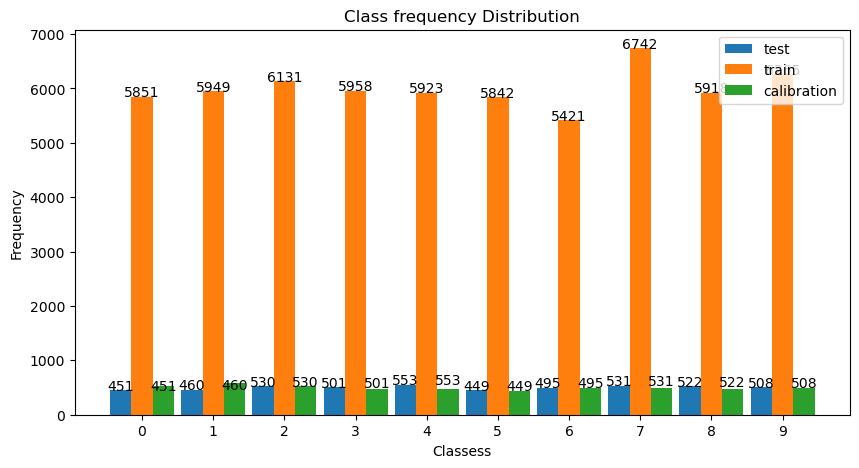

In [11]:
from collections import Counter

class_counter_train=Counter()
class_counter_test=Counter()
class_counter_calib=Counter()

for inps, labels in train_loader:
    labels=labels.cpu().numpy()
    class_counter_train.update(labels.tolist())
    
for inps, labels in test_loader:
    labels=labels.cpu().numpy()
    class_counter_test.update(labels.tolist())
    
for inps, labels in calib_loader:
    labels=labels.cpu().numpy()
    class_counter_calib.update(labels.tolist())
    
classes, train_count=map(list, zip(*class_counter_train.items()))
classes, test_count=map(list, zip(*class_counter_test.items()))
classes, calib_count=map(list, zip(*class_counter_calib.items()))

print(classes, train_count, test_count, calib_count)

def add_labels(x, y):
    for i in range(len(x)):
        plt.text(x[i], y[i], y[i], ha='center')
    
plt.figure(figsize=(10,5))
plt.bar([x-0.3 for x in classes], test_count, width=0.3, label='test')
add_labels([x-0.3 for x in classes], test_count)
plt.bar(classes, train_count, width=0.3, label='train')
add_labels(classes, train_count)
plt.bar([x+0.3 for x in classes], calib_count, width=0.3, label='calibration')
add_labels([x+0.3 for x in classes], test_count)

plt.xlabel('Classess')
plt.ylabel('Frequency')
plt.xticks(classes)
plt.title('Class frequency Distribution')
plt.legend()
plt.show()

In [25]:
classes, train_count, test_count, calib_count= [5, 0, 7, 1, 8, 2, 6, 4, 3, 9], [6265, 6131, 5918, 5923, 5421, 6742, 5842, 5851, 5958, 5949], [449, 451, 531, 460, 522, 530, 495, 553, 501, 508], [443, 529, 497, 582, 466, 537, 498, 481, 480, 487]

In [18]:
image, label = train_dataset[0]
#image=torch.tensor(image)
print(torch.min(image), torch.max(image))  # Check if values are extreme0.1307,), (0.3081
print(f"Expected range = {((0-0.1307)/0.3081)} - {((1-0.1307)/0.3081)}")

tensor(-0.4242) tensor(2.7960)
Expected range = -0.424212917883804 - 2.82148653034729


In [19]:
# Load pretrained VGG19 and modify final layer
model = models.vgg19(pretrained=False)
model.classifier[6] = nn.Linear(4096, 10)  # MNIST has 10 classes
model = model.to(device)

/home/sanjayv/anaconda3/envs/uc/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/sanjayv/anaconda3/envs/uc/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [20]:
from torchsummary import summary

summary(model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [21]:
def calculate_metrics(predictions, targets):
    accuracy = accuracy_score(targets, predictions)
    precision = precision_score(targets, predictions, average='macro')
    recall = recall_score(targets, predictions, average='macro')
    return accuracy, precision, recall

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 5

In [26]:
def train_model(model, train_loader, optimizer, device, accumulation_steps=4):
    model.train()
    total_loss = 0
    predictions = []
    targets = []

    optimizer.zero_grad()

    for batch_idx, (inputs, labels) in enumerate(tqdm(train_loader, desc="Training")):
        inputs, labels = inputs.to(device), labels.to(device)

        logits = model(inputs)  # Forward pass
        #print(f"labels={labels} Logits={logits}")
        
        loss = criterion(logits, labels)#, class_weights)  # Compute loss

        loss.backward()  # Backpropagation
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):  # Update only every accumulation_steps batches
            optimizer.step()
            optimizer.zero_grad()  # Clear gradients

        total_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        predictions.extend(predicted.cpu().numpy())
        targets.extend(labels.cpu().numpy())
        
    accuracy, precision, recall=calculate_metrics(predictions, targets)

    return (total_loss / len(train_loader)), accuracy, precision, recall

In [27]:
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    all_probs = []
    all_preds = []
    all_labels = []
    all_loss = []

    epistemic_uncertainties = []
    aleatoric_uncertainties = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.to(device)

           
            logits = model(images)
            _, predicted = torch.max(logits, 1)
            
            

            # Accuracy
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

                       
            loss = criterion(logits, labels)

            all_probs.extend(logits.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            

    accuracy, precision, recall=calculate_metrics(all_preds, all_labels)
    print(f'Test Accuracy: {100 * correct / total:.2f}%')

    return {
        "accuracy": accuracy,
        "precision":precision,
        "recall":recall,
        "predictions": all_preds,
        "labels": all_labels,
        "probs": all_probs,
        
    }


In [28]:

for epoch in range(epochs):
    train_loss, accuracy, precision, recall = train_model(model, train_loader, optimizer, device)
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy:{accuracy}, Precision:{precision}, recall: {recall}")
    
torch.save(model.state_dict(),'vgg19_mnist.pth')

Training:   0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 1/5, Loss: 0.1651, Accuracy:0.95045, Precision:0.949928751959489, recall: 0.9499152545891374


Training:   0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 2/5, Loss: 0.0644, Accuracy:0.98075, Precision:0.9806230422039951, recall: 0.9806036554552939


Training:   0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 3/5, Loss: 0.0481, Accuracy:0.9857, Precision:0.9856400410374156, recall: 0.9855771939491274


Training:   0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 4/5, Loss: 0.0379, Accuracy:0.9885166666666667, Precision:0.9884514900117128, recall: 0.9884465553487276


Training:   0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 5/5, Loss: 0.0334, Accuracy:0.9902666666666666, Precision:0.9902238293694895, recall: 0.9901870781838216


In [29]:
test_metrics_dict=evaluate(model, test_loader, device)
print(f"Acc= {test_metrics_dict['accuracy']} Precision={test_metrics_dict['precision']} Recall={test_metrics_dict['recall']}")

Evaluating:   0%|          | 0/2500 [00:00<?, ?it/s]

Test Accuracy: 99.42%
Acc= 0.9942 Precision=0.9941598686297433 Recall=0.9941196935732804


In [38]:
all_logits=np.stack(test_metrics_dict['probs'], axis=0)
all_probs=F.softmax(torch.tensor(all_logits), dim=1)
all_labels=np.stack(test_metrics_dict['labels'], axis=0)

In [40]:
all_labels

array([5, 0, 5, ..., 8, 2, 2])

In [45]:
from sklearn.calibration import calibration_curve
def plot_calibration(pred_probs, true_labels, n_bins=10, num_classes=10):
    
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    for class_idx in range(num_classes):
        prob_class = pred_probs[:, class_idx]
        true_class = (true_labels == class_idx).astype(int)

        fraction_of_positives, mean_predicted_value = calibration_curve(
            true_class, prob_class, n_bins=n_bins, strategy='uniform'
        )
        print(fraction_of_positives,mean_predicted_value)

        ax = axes[class_idx]
        ax.plot(mean_predicted_value, fraction_of_positives, marker='o', label=f'Class {class_idx}')
        ax.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Perfect calibration
        ax.set_title(f'Class {class_idx}')
        ax.set_xlabel('Confidence')
        ax.set_ylabel('Accuracy')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.grid(True)
    

[2.20022002e-04 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 9.95555556e-01] [8.74483297e-05 1.39060169e-01 2.73192495e-01 4.38085884e-01
 5.61880469e-01 8.51782799e-01 9.98981527e-01]
[0.  0.5 0.5 0.  1.  1. ] [1.58036113e-04 2.06128404e-01 3.82048413e-01 4.27437335e-01
 7.92025030e-01 9.99260196e-01]
[0.        0.        0.        0.5       0.        0.        1.
 0.9979716] [1.92376030e-04 1.57547984e-01 2.52179921e-01 3.46124157e-01
 5.70481598e-01 6.39158666e-01 8.29508066e-01 9.99320985e-01]
[0.  0.5 0.  0.  0.5 0.  1. ] [1.90532221e-04 1.60967112e-01 2.60087714e-01 3.61252934e-01
 6.61408603e-01 7.63861775e-01 9.99540188e-01]
[0.         0.         0.5        0.5        1.         0.25
 0.         0.         1.         0.99797571] [2.40368764e-04 1.47425294e-01 2.10662909e-01 3.07049498e-01
 4.02089864e-01 5.33598036e-01 6.96037292e-01 7.16313124e-01
 8.66149068e-01 9.99593946e-01]
[4.40044004e-04 3.33333333e-01 1.00000000e+00 0.00000000e+00
 0.000

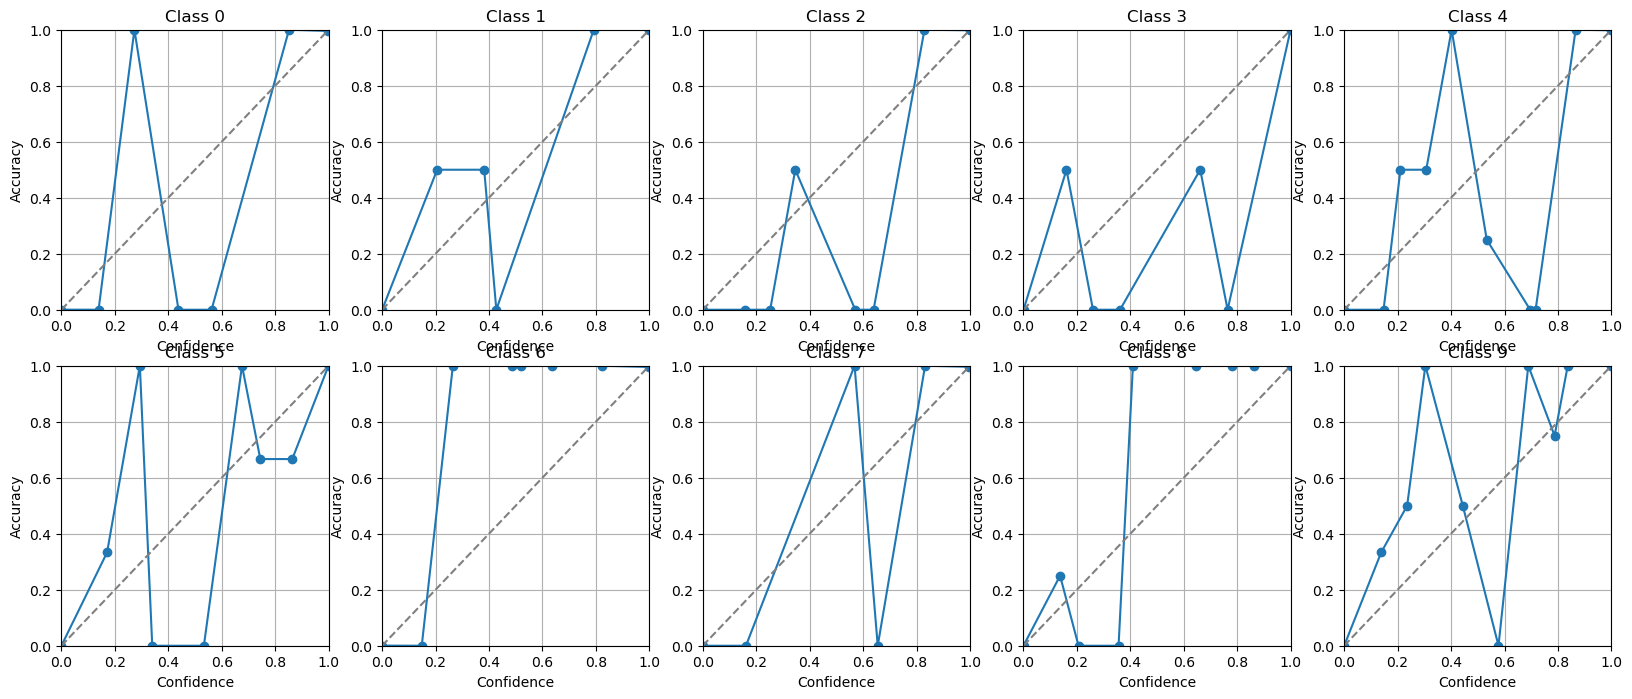

In [46]:
#calib_metrics=evaluate(model, calib_loader, device)
plot_calibration(all_probs, all_labels)

In [45]:
num_epochs = 20  # Set your desired number of epochs
best_acc = 0
best_loss = np.inf
best_recall = 0
v_a = []
v_l = []
t_a = []
t_l = []
for epoch in range(num_epochs):
    train_loss, train_accuracy, train_precision, train_recall = train_model(model, train_loader, optimizer, device)
    test_loss, test_accuracy, test_precision, test_recall = validate(model, test_loader, optimizer, device)
    
    if (best_loss > test_loss):
        best_loss = test_loss
        checkpoint = { 
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict()}
        torch.save(checkpoint, f"/Models/MNIST/min_loss_model.pt")
        
    t_a.append(train_accuracy)
    t_l.append(train_loss)
    v_a.append(test_accuracy)
    v_l.append(test_loss)
    
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f} |'
          f'Train Precision: {train_precision:.4f} | Train Recall: {train_recall:.4f}')
    print(f'Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f} | '
          f'Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f}')
    
    
checkpoint = { 
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict()}
torch.save(checkpoint, f"/Models/MNIST/final_model.pt")

NameError: name 'train' is not defined

In [21]:
print(torch.sigmoid(torch.tensor(181.1905)))
print(torch.log(1-torch.sigmoid(torch.tensor(181.1905))))

tensor(1.)
tensor(-inf)
